In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#df_plays = pd.read_csv('data/game_plays.csv')
#df_faceoffs = df_plays[df_plays['event'] == 'Faceoff']

In [2]:
#df_faceoffs.head()

#join game_plays_players to df_faceoffs by 'play_id'
#player_id_plays = pd.read_csv('data/game_plays_players.csv')
#df_faceoffs = df_faceoffs.merge(player_id_plays, on='play_id', how='left')

In [10]:
df_player_personal = pd.read_csv('data/player_info.csv')
df_player_stats = pd.read_csv('data/game_skater_stats.csv')

#group by player id and count faceoffs taken and faceoffs won
df_faceoffs = df_player_stats.groupby('player_id').agg(
    total_faceoffs=('faceoffTaken', 'sum'),
    faceoffs_won=('faceOffWins', 'sum')
).reset_index()
df_faceoff_count = df_player_stats.groupby('player_id').size().reset_index(name='faceoffTaken')


Text(0, 0.5, 'Faceoffs Taken')

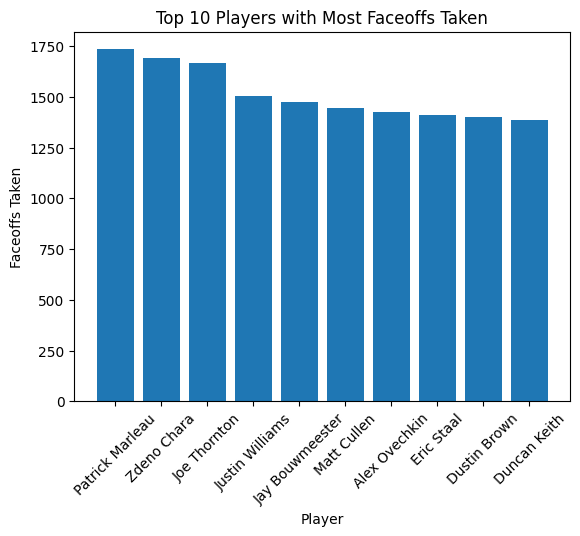

In [6]:
#join df_faceoff_count on df_players_personal to keep first_name, last_name, faceoffTaken
df_faceoff_count = df_faceoff_count.merge(df_player_personal[['player_id', 'firstName', 'lastName']], on='player_id',
                                          how='left')
#graph bar chart of top 10 players with most faceoffs taken
df_faceoff_count = df_faceoff_count.sort_values(by='faceoffTaken', ascending=False).head(10)
plt.bar(df_faceoff_count['firstName'] + ' ' + df_faceoff_count['lastName'], df_faceoff_count['faceoffTaken'])
plt.xticks(rotation=45)
plt.title('Top 10 Players with Most Faceoffs Taken')
plt.xlabel('Player')
plt.ylabel('Faceoffs Taken')


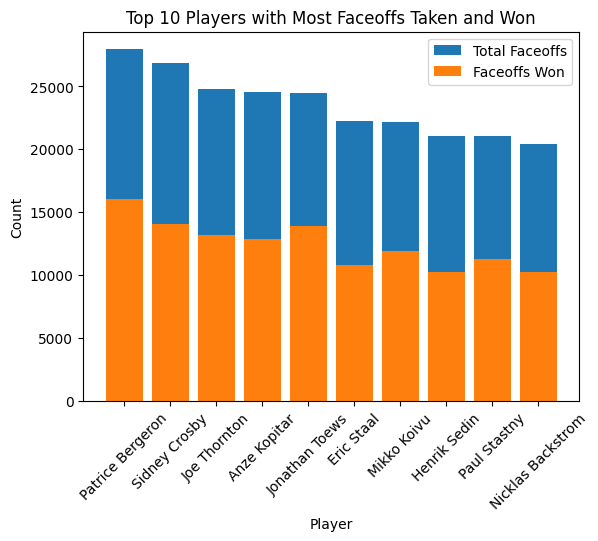

     firstName   lastName  win_percentage
1550   Patrice   Bergeron       57.316680
1772    Sidney     Crosby       52.347742
798        Joe   Thornton       53.156790
1781      Anze    Kopitar       52.660334
1967  Jonathan      Toews       56.743616
1510      Eric      Staal       48.483894
1273     Mikko      Koivu       53.778480
1027    Henrik      Sedin       48.705402
1769      Paul    Stastny       53.689519
1951   Nicklas  Backstrom       50.203362


In [11]:
#stacked bar chart based of df_faceoffs, create stacked bar chart of total faceoffs and wins
df_faceoffs = df_faceoffs.merge(df_player_personal[['player_id', 'firstName', 'lastName']], on='player_id', how='left')
df_faceoffs = df_faceoffs.sort_values(by='total_faceoffs', ascending=False).head(10)
plt.bar(df_faceoffs['firstName'] + ' ' + df_faceoffs['lastName'], df_faceoffs['total_faceoffs'], label='Total Faceoffs')
plt.bar(df_faceoffs['firstName'] + ' ' + df_faceoffs['lastName'], df_faceoffs['faceoffs_won'], label='Faceoffs Won')
plt.xticks(rotation=45)
plt.title('Top 10 Players with Most Faceoffs Taken and Won')
plt.xlabel('Player')
plt.ylabel('Count')
plt.legend()
plt.show()
#print win % for each player
df_faceoffs['win_percentage'] = df_faceoffs['faceoffs_won'] / df_faceoffs['total_faceoffs'] * 100
print(df_faceoffs[['firstName', 'lastName', 'win_percentage']])


<Figure size 1500x700 with 0 Axes>

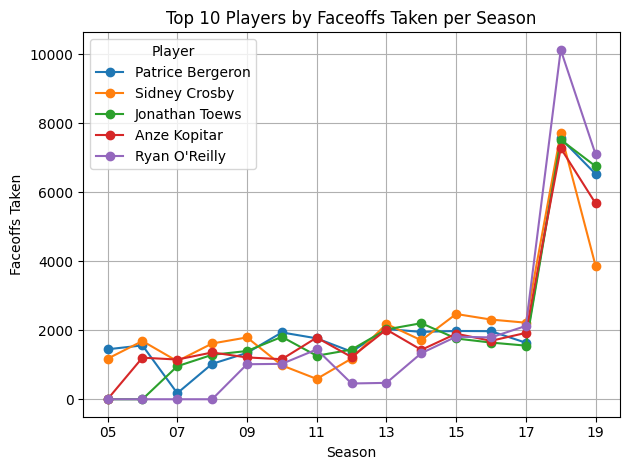

In [2]:
game_skater_stats = pd.read_csv('data/game_skater_stats.csv')
game = pd.read_csv('data/game.csv')
player_info = pd.read_csv('data/player_info.csv')

stats_with_season = pd.merge(
    game_skater_stats[['game_id', 'player_id', 'faceoffTaken', 'faceOffWins']],
    game[['game_id', 'season']],
    on='game_id'
)
faceoffs_by_season = stats_with_season.groupby(['season', 'player_id'])['faceoffTaken'].sum().reset_index()
df = faceoffs_by_season.pivot(index='season', columns='player_id', values='faceoffTaken').fillna(-1).astype(int)

faceoff_wins_by_season = stats_with_season.groupby(['season', 'player_id'])['faceOffWins'].sum().reset_index()

# Get player names for columns
player_id_to_name = player_info.set_index('player_id').apply(lambda x: f"{x['firstName']} {x['lastName']}", axis=1)
df.columns = [player_id_to_name.get(pid, str(pid)) for pid in df.columns]

# Sum total faceoffs across all seasons for each player
top10_players = df.sum(axis=0).sort_values(ascending=False).head(5).index

# Filter DataFrame to only include the top 10 players
df_top10 = df[top10_players]
df_top10 = df_top10[df_top10.index > 20042005]  #TODO surely doing this filter here won't cause problems later
df_top10.index = df_top10.index.astype(str).str[2:4]

# Plot
plt.figure(figsize=(15, 7))
df_top10.plot(kind='line', marker='o')
plt.title("Top 10 Players by Faceoffs Taken per Season")
plt.xlabel("Season")
plt.ylabel("Faceoffs Taken")
plt.legend(title="Player")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def simulate_random_fow_percent(fow_stats, player_id_to_name, n_simulations=1, random_seed=0):

    np.random.seed(random_seed)
    results = []
    for _, row in fow_stats.iterrows():
        season = row['season']
        player = row['player_id']
        n_faceoff = row['faceoffTaken']


        sim_wins = np.random.binomial(n=n_faceoff, p=0.5, size=n_simulations)
        sim_pcts = sim_wins / n_faceoff if n_faceoff > 0 else np.nan


        results.append({
            'season': season,
            'player_id': player,
            'faceoffTaken': n_faceoff,
            'sim_win_pct_mean': np.mean(sim_pcts),
            'sim_win_pct_std': np.std(sim_pcts),
            'sim_win_pct_all': sim_pcts if n_simulations > 1 else sim_pcts[0]
        })
    return pd.DataFrame(results)


fow_stats = faceoffs_by_season.copy()
fow_stats = fow_stats[fow_stats['season'] > 20042005]

faceoff_wins_by_season = faceoff_wins_by_season[faceoff_wins_by_season['season'] > 20042005]

fow_stats = pd.merge(fow_stats, faceoff_wins_by_season, on=['season', 'player_id'], how='left')


sim_results = simulate_random_fow_percent(fow_stats, player_id_to_name, n_simulations=1000)

In [5]:
player_actual = (
    fow_stats.groupby('player_id')
    .agg({'faceOffWins': 'sum', 'faceoffTaken': 'sum'})
    .reset_index()
)
player_actual['actual_win_pct'] = player_actual[('faceO'
                                                 'ffWins')] / player_actual['faceoffTaken']
sim_results = sim_results.dropna()
# Calculate player's career random mean win %
player_sim = (
    sim_results.groupby('player_id')
    .apply(lambda x: np.sum(x['sim_win_pct_mean'] * x['faceoffTaken']) / np.sum(x['faceoffTaken']))
    .reset_index(name='sim_win_pct_mean_weighted')
)
# Join
player_combined = pd.merge(player_actual, player_sim, on='player_id')

observed_var = np.var(player_combined['actual_win_pct'] * 100, ddof=0)
luck_var = np.var(player_combined['sim_win_pct_mean_weighted'] * 100, ddof=0)
skill_component = 1 - luck_var / observed_var

C:\Users\ninja\AppData\Local\Temp\ipykernel_17616\2512167601.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sum(x['sim_win_pct_mean'] * x['faceoffTaken']) / np.sum(x['faceoffTaken']))


In [4]:
#player_combined.to_csv('faceoff_with_sim.csv')
faceoffs_by_season.to_csv('faceoffs_by_season.csv')
faceoff_wins_by_season.to_csv('faceoff_wins_by_season.csv')

In [36]:
# player_combined['skill_component'] = player_combined['actual_win_pct'] - player_combined['sim_win_pct_mean_weighted']
# player_combined['luck_component'] = player_combined['sim_win_pct_mean_weighted']
#

# player_combined['check'] = player_combined['skill_component'] + player_combined['luck_component']
#
# print(player_combined[['check','player_id', 'actual_win_pct', 'skill_component', 'luck_component']].head())

      check  player_id  actual_win_pct  skill_component  luck_component
0  0.544304    8445000        0.544304         0.043241        0.501063
1  0.384615    8445550        0.384615        -0.111846        0.496462
2  0.166667    8445575        0.166667        -0.327333        0.494000
3  0.593191    8445735        0.593191         0.093057        0.500134
4  0.000000    8445739        0.000000        -0.491500        0.491500


C:\Users\ninja\PycharmProjects\thesisv0\.venv\Lib\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
C:\Users\ninja\PycharmProjects\thesisv0\.venv\Lib\site-packages\matplotlib\patches.py:797: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
C:\Users\ninja\PycharmProjects\thesisv0\.venv\Lib\site-packages\matplotlib\transforms.py:2037: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty


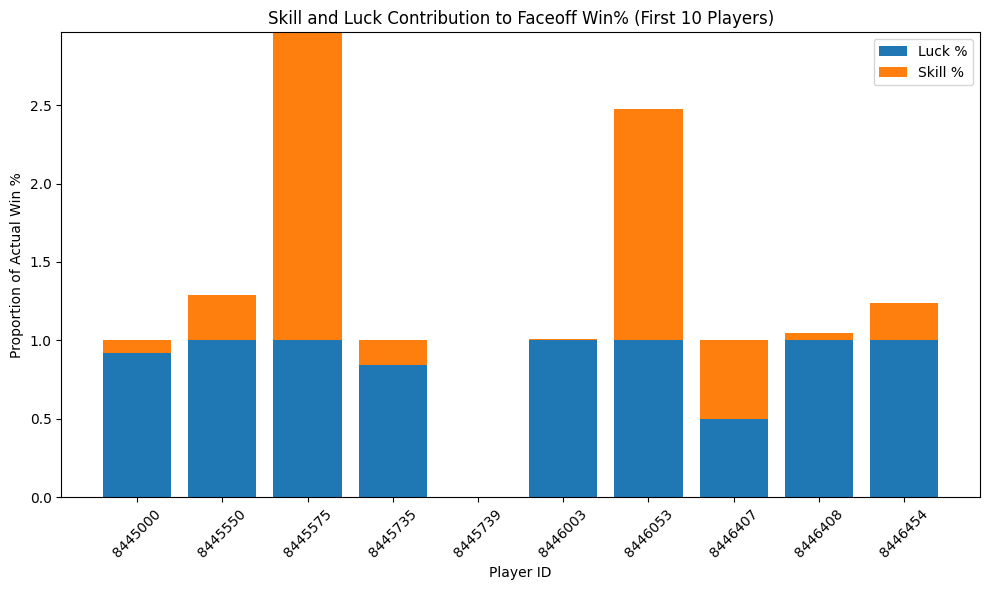

In [37]:
# player_combined['skill_pct'] = (player_combined['actual_win_pct'] - player_combined['sim_win_pct_mean_weighted']) / player_combined['actual_win_pct']
# player_combined['luck_pct'] = player_combined['sim_win_pct_mean_weighted'] / player_combined['actual_win_pct']
#
# # Select the first 10 players
# player_combined10 = player_combined.head(10)
#
# # Prepare data for stacked bar chart
# labels = player_combined10['player_id'].astype(str)
# skill = player_combined10['skill_pct']
# luck = player_combined10['luck_pct']
#
# # Create a stacked bar chart
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.bar(labels, luck, label='Luck %')
# ax.bar(labels, skill, bottom=luck, label='Skill %')
#
# ax.set_ylabel('Proportion of Actual Win %')
# ax.set_xlabel('Player ID')
# ax.set_title('Skill and Luck Contribution to Faceoff Win% (First 10 Players)')
# ax.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('faceoff_with_sim.csv',index_col=0)

df['win_pct_stdev'] = np.sqrt(df['actual_win_pct'] * (1 - df['actual_win_pct']) / df['faceoffTaken'])
df['sim_win_pct_stdev'] = np.sqrt(df['sim_win_pct_mean_weighted'] * (1 - df['sim_win_pct_mean_weighted']) / df['sim_win_pct_mean_weighted'])
print('boink')

var_obs = df['actual_win_pct'].var(ddof=0)  # population variance

# 2. Calculate Var(rand): expected binomial variance (averaged)
var_rand = np.mean(df['actual_win_pct'] * (1 - df['actual_win_pct']) / df['faceoffTaken'])

# 3. Solve for Var(true)
var_true = var_obs - var_rand

print(f'Var(obs):  {var_obs}')
print(f'Var(rand): {var_rand}')
print(f'Var(true): {var_true}')